In [1]:
from osgeo import gdal
from PIL import Image
from osgeo import gdal_array
import pylab as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import geopandas as gpd
from sklearn.model_selection import KFold 
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

/nfshome/nj935/.conda/envs/remote_sensing/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Import Houston training image
This is a raster created by Texas urban planning which classifies land into 10 categories, each with a unique value.

In [ ]:
# Read in Houston training image
houston_read = gdal.Open('data/houston/land_2015_raster.tif', gdal.GA_ReadOnly)

h_train = np.zeros((houston_read.RasterYSize, houston_read.RasterXSize),
               gdal_array.GDALTypeCodeToNumericTypeCode(houston_read.GetRasterBand(1).DataType))

h_train = houston_read.ReadAsArray()


In [98]:
# How many pixels are in each class?
classes = np.unique(h_train)

# Iterate over all class labels in the ROI image, printing out some information
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(h_train == c).sum()))

Class 0 contains 711 pixels
Class 1 contains 4741401 pixels
Class 2 contains 701683 pixels
Class 3 contains 1764890 pixels
Class 4 contains 4075836 pixels
Class 5 contains 1605261 pixels
Class 6 contains 549946 pixels
Class 7 contains 6811176 pixels
Class 8 contains 11811106 pixels
Class 9 contains 4659188 pixels
Class 10 contains 7450182 pixels
Class 255 contains 40084894 pixels


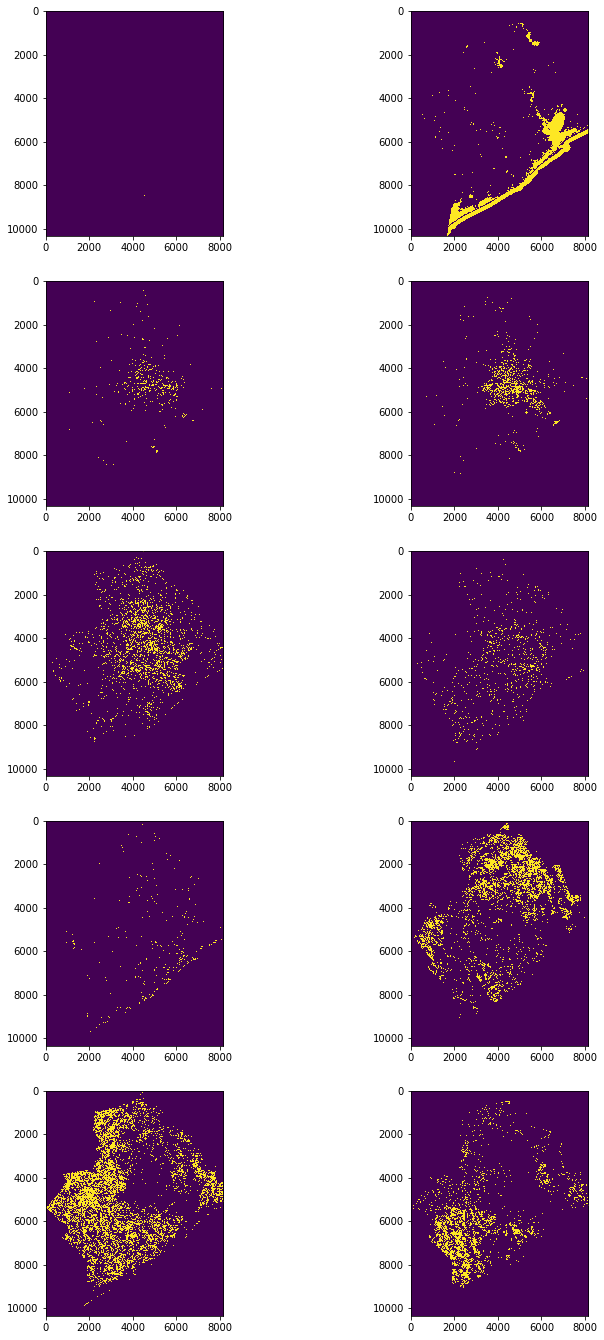

In [112]:
# Visualize training image from its np array
fig, axs = plt.subplots(5,2, figsize=(12, 24), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(10):
    axs[i].imshow(h_train==i)
    

#### Note, the classes are:
0: open water
1: developed high intensity
2: developed med intensity
3: developed low intensity
4: developed open space
5-10: barren, forest, pasture, crops, wetlands

We want to reclass this as follows:

0: open water
1: developed high and med intensity
2: developed low intensity and developed open space
3: non-urban land

In [105]:
# Reclass the pixels in our new categories

category_dict = {0:255, 1:1, 2:2, 3:2, 4:3, 5:3, 6:4, 7:4, 8:4, 9:4, 10:4, 255:255}

h_train_cat = np.vectorize(category_dict.get)(h_train.reshape(-1,1))

# Reshape the categorized image to its proper x,y shape
h_train_cat=h_train_cat.reshape(h_train.shape)
print(h_train_cat.shape)

(10342, 8147)


In [106]:
# See the new unique values

classes = np.unique(h_train_cat)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,
                                                 n=(h_train_cat == c).sum()))

Class 1 contains 4741401 pixels
Class 2 contains 2466573 pixels
Class 3 contains 5681097 pixels
Class 4 contains 31281598 pixels
Class 255 contains 40085605 pixels


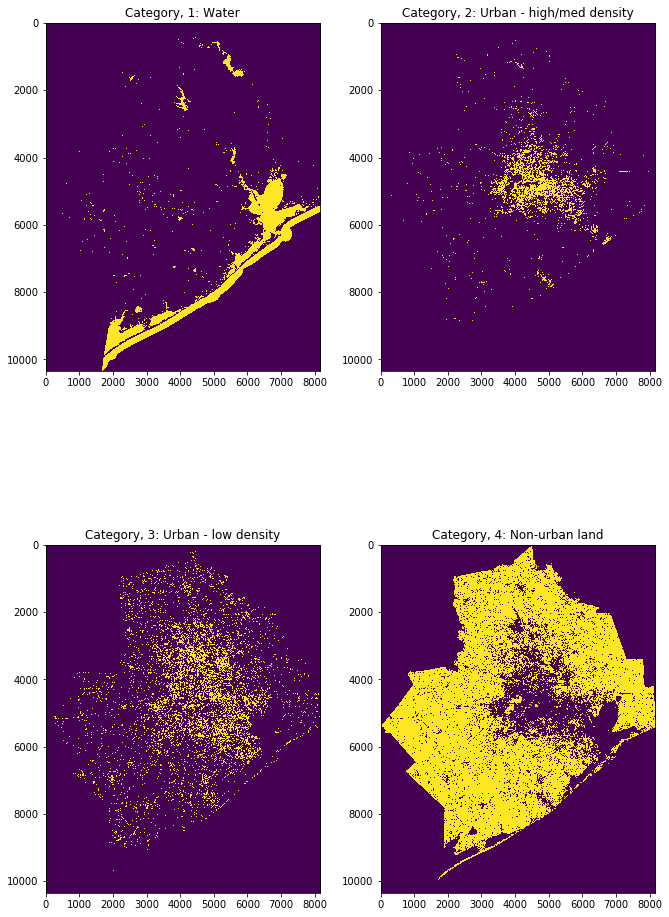

In [108]:
# Visualize categorized training image from its np array
fig, axs = plt.subplots(2,2, figsize=(12, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):

    axs[i].imshow(h_train_cat==i+1)
    axs[i].set_title("Category, "+titles[i])
